<a href="https://colab.research.google.com/github/debjit15005/human-face-gan/blob/main/human_face_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
project_name = 'human-face-gan'

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

DATA_DIR = '/content/drive/MyDrive/cpData-Mar2023'
print(os.listdir(DATA_DIR))

['Images']


In [7]:
print(os.listdir(DATA_DIR + "/Images")[:10])

['S023.jpg', 'S011.jpg', 'S021.jpg', 'S003.jpg', 'S020.jpg', 'S006.jpg', 'S013.jpeg', 'S002.jpeg', 'S012.jpeg', 'S004.jpg']


In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

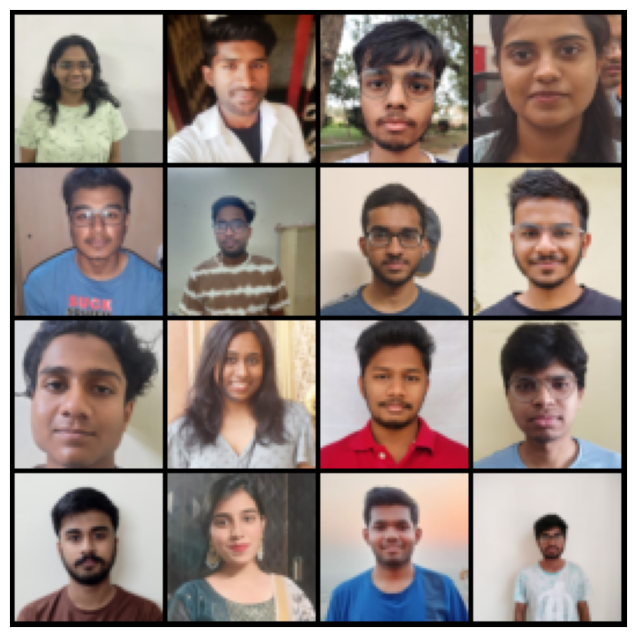

In [14]:
show_batch(train_dl)

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)

In [21]:
import torch.nn as nn

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 128

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([16, 3, 64, 64])


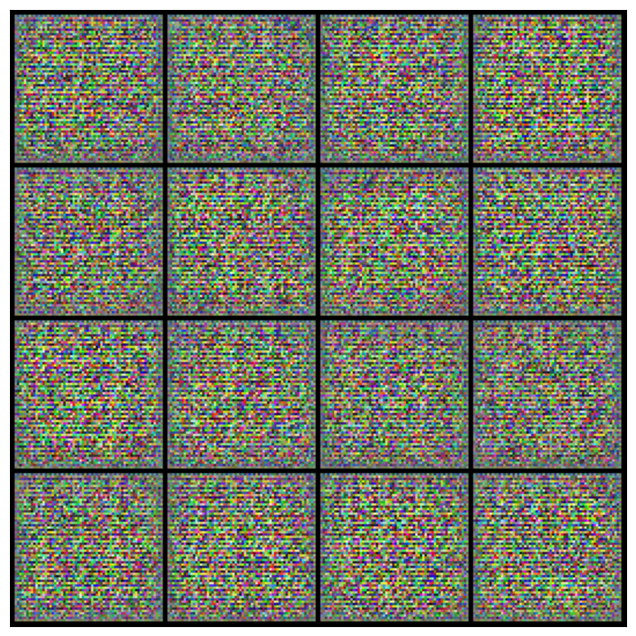

In [26]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

In [33]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


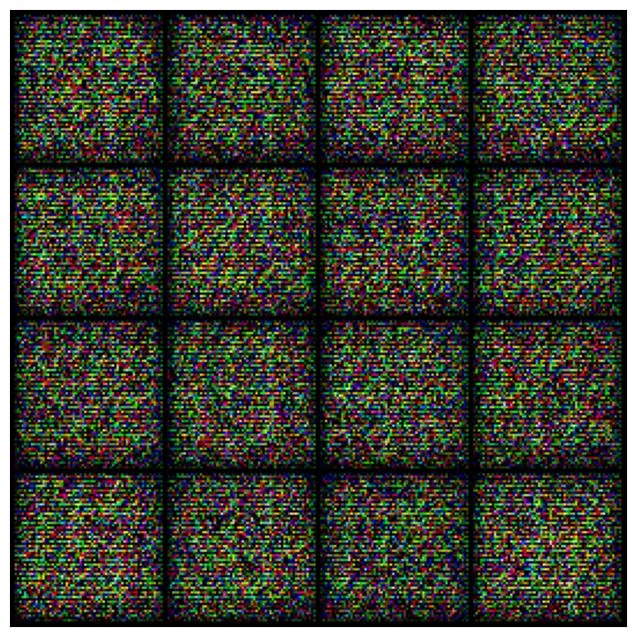

In [34]:
save_samples(0, fixed_latent)

In [35]:
# jovian.commit(project=project_name, environment=None)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.2, 0.95))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.3, 0.9))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 45

In [39]:
# jovian.reset()
# jovian.log_hyperparams(lr=lr, epochs=epochs)

In [40]:
history = fit(epochs, lr)

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [1/45], loss_g: 6.7471, loss_d: 0.0569, real_score: 0.9660, fake_score: 0.0205
Saving generated-images-0001.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [2/45], loss_g: 12.1210, loss_d: 0.0713, real_score: 0.9710, fake_score: 0.0389
Saving generated-images-0002.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [3/45], loss_g: 8.5166, loss_d: 0.0259, real_score: 0.9766, fake_score: 0.0006
Saving generated-images-0003.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [4/45], loss_g: 6.8472, loss_d: 0.0285, real_score: 0.9937, fake_score: 0.0214
Saving generated-images-0004.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [5/45], loss_g: 3.5193, loss_d: 0.7760, real_score: 0.9071, fake_score: 0.4615
Saving generated-images-0005.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [6/45], loss_g: 2.2606, loss_d: 0.5599, real_score: 0.6486, fake_score: 0.0634
Saving generated-images-0006.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [7/45], loss_g: 3.7686, loss_d: 0.3433, real_score: 0.9465, fake_score: 0.2136
Saving generated-images-0007.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [8/45], loss_g: 3.1148, loss_d: 0.7000, real_score: 0.7514, fake_score: 0.2545
Saving generated-images-0008.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [9/45], loss_g: 4.2984, loss_d: 1.0950, real_score: 0.6914, fake_score: 0.4388
Saving generated-images-0009.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [10/45], loss_g: 4.1502, loss_d: 0.8412, real_score: 0.8197, fake_score: 0.4286
Saving generated-images-0010.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [11/45], loss_g: 1.9545, loss_d: 1.1752, real_score: 0.4024, fake_score: 0.0105
Saving generated-images-0011.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [12/45], loss_g: 4.2085, loss_d: 0.7146, real_score: 0.9680, fake_score: 0.4318
Saving generated-images-0012.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [13/45], loss_g: 2.7135, loss_d: 0.3930, real_score: 0.8186, fake_score: 0.1419
Saving generated-images-0013.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [14/45], loss_g: 0.8057, loss_d: 0.9042, real_score: 0.5190, fake_score: 0.0205
Saving generated-images-0014.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [15/45], loss_g: 3.7754, loss_d: 0.4652, real_score: 0.8402, fake_score: 0.2056
Saving generated-images-0015.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [16/45], loss_g: 3.6254, loss_d: 0.1823, real_score: 0.9441, fake_score: 0.1125
Saving generated-images-0016.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [17/45], loss_g: 3.3938, loss_d: 0.2774, real_score: 0.8036, fake_score: 0.0324
Saving generated-images-0017.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [18/45], loss_g: 5.2799, loss_d: 0.2809, real_score: 0.9465, fake_score: 0.1783
Saving generated-images-0018.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [19/45], loss_g: 4.3405, loss_d: 0.3841, real_score: 0.9198, fake_score: 0.2165
Saving generated-images-0019.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [20/45], loss_g: 4.8547, loss_d: 0.3621, real_score: 0.9741, fake_score: 0.2742
Saving generated-images-0020.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [21/45], loss_g: 4.4712, loss_d: 0.3293, real_score: 0.7929, fake_score: 0.0305
Saving generated-images-0021.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [22/45], loss_g: 4.4246, loss_d: 0.4326, real_score: 0.8526, fake_score: 0.2053
Saving generated-images-0022.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [23/45], loss_g: 4.2317, loss_d: 0.1758, real_score: 0.9016, fake_score: 0.0635
Saving generated-images-0023.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [24/45], loss_g: 4.5090, loss_d: 0.8876, real_score: 0.9164, fake_score: 0.4143
Saving generated-images-0024.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [25/45], loss_g: 4.4454, loss_d: 0.2322, real_score: 0.9792, fake_score: 0.1692
Saving generated-images-0025.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [26/45], loss_g: 3.1825, loss_d: 0.2673, real_score: 0.9118, fake_score: 0.1457
Saving generated-images-0026.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [27/45], loss_g: 3.1059, loss_d: 0.5757, real_score: 0.6581, fake_score: 0.0709
Saving generated-images-0027.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [28/45], loss_g: 3.4480, loss_d: 0.5108, real_score: 0.6440, fake_score: 0.0096
Saving generated-images-0028.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [29/45], loss_g: 2.0840, loss_d: 0.3688, real_score: 0.7791, fake_score: 0.0186
Saving generated-images-0029.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [30/45], loss_g: 3.2199, loss_d: 0.3662, real_score: 0.8310, fake_score: 0.1431
Saving generated-images-0030.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [31/45], loss_g: 3.3678, loss_d: 0.5586, real_score: 0.6347, fake_score: 0.0073
Saving generated-images-0031.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [32/45], loss_g: 3.1288, loss_d: 0.2417, real_score: 0.8466, fake_score: 0.0565
Saving generated-images-0032.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [33/45], loss_g: 4.6731, loss_d: 0.1573, real_score: 0.8973, fake_score: 0.0418
Saving generated-images-0033.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [34/45], loss_g: 1.2298, loss_d: 0.2885, real_score: 0.8135, fake_score: 0.0349
Saving generated-images-0034.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [35/45], loss_g: 3.7413, loss_d: 0.2174, real_score: 0.8645, fake_score: 0.0513
Saving generated-images-0035.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [36/45], loss_g: 6.1675, loss_d: 0.1867, real_score: 0.9821, fake_score: 0.1407
Saving generated-images-0036.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [37/45], loss_g: 7.2717, loss_d: 0.3962, real_score: 0.9691, fake_score: 0.2218
Saving generated-images-0037.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [38/45], loss_g: 4.5940, loss_d: 0.1389, real_score: 0.9828, fake_score: 0.1068
Saving generated-images-0038.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [39/45], loss_g: 2.8630, loss_d: 0.2732, real_score: 0.8119, fake_score: 0.0211
Saving generated-images-0039.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [40/45], loss_g: 4.0504, loss_d: 1.0067, real_score: 0.5165, fake_score: 0.0035
Saving generated-images-0040.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [41/45], loss_g: 2.5960, loss_d: 0.1841, real_score: 0.9271, fake_score: 0.0912
Saving generated-images-0041.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [42/45], loss_g: 5.8741, loss_d: 0.1351, real_score: 0.9788, fake_score: 0.0789
Saving generated-images-0042.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [43/45], loss_g: 4.2109, loss_d: 0.1160, real_score: 0.9899, fake_score: 0.0840
Saving generated-images-0043.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [44/45], loss_g: 4.7760, loss_d: 0.2198, real_score: 0.8356, fake_score: 0.0021
Saving generated-images-0044.png


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch [45/45], loss_g: 4.7037, loss_d: 0.1551, real_score: 0.8827, fake_score: 0.0198
Saving generated-images-0045.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

In [43]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [44]:
from IPython.display import Image

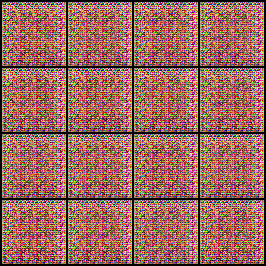

In [45]:
Image('./generated/generated-images-0001.png')

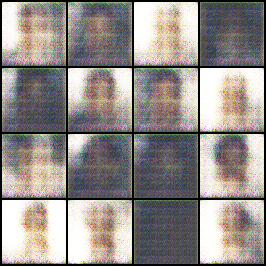

In [46]:
Image('./generated/generated-images-0005.png')

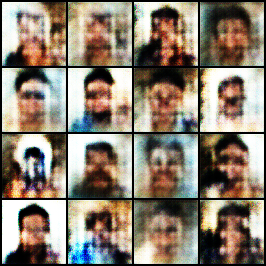

In [47]:
Image('./generated/generated-images-0010.png')

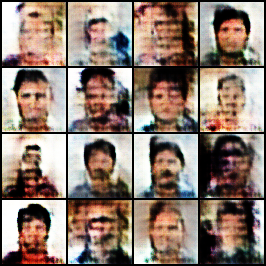

In [48]:
Image('./generated/generated-images-0020.png')

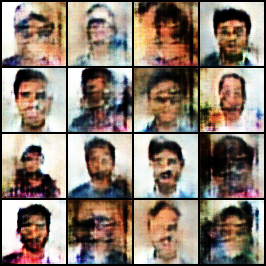

In [49]:
Image('./generated/generated-images-0025.png')

In [50]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

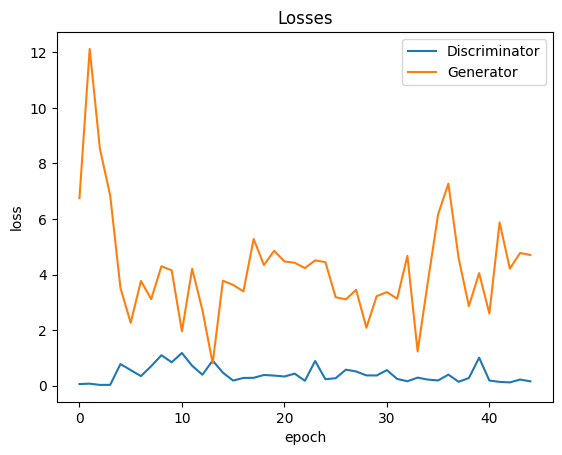

In [51]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
plt.savefig('losses.png')

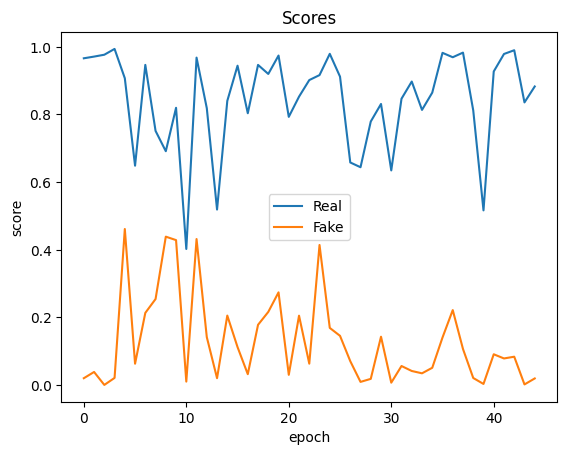

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.savefig('scores.png')

In [53]:
!zip -r /content/images.zip /content/generated

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0043.png (deflated 0%)
  adding: content/generated/generated-images-0038.png (deflated 0%)
  adding: content/generated/generated-images-0033.png (deflated 0%)
  adding: content/generated/generated-images-0035.png (deflated 0%)
  adding: content/generated/generated-images-0044.png (deflated 0%)
  adding: content/generated/generated-images-0016.png (deflated 0%)
  adding: content/generated/generated-images-0039.png (deflated 0%)
  adding: content/generated/generated-images-0008.png (deflated 0%)
  adding: content/generated/generated-images-0000.png (deflated 0%)
  adding: content/generated/generated-images-0006.png (deflated 0%)
  adding: content/generated/generated-images-0007.png (deflated 0%)
  adding: content/generated/generated-images-0023.png (deflated 0%)
  adding: content/generated/generated-images-0014.png (deflated 0%)
  adding: content/generated/generated-images-0028.png (deflated 0%)
  addin

In [54]:
from google.colab import files
files.download("/content/images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import visualkeras

# model = generator
# visualkeras.draw_convnet(model).show()